# Computer Chess Tourney


## Imports and Packages

In [ ]:
pip install chess

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.1/149.1 KB 5.0 MB/s eta 0:00:00


In [283]:
import random
import time
import typing
import math

import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np


from google.colab import files

import urllib3 as urllib # for reading in FENs
import pandas as pd

import chess
import chess.svg
import chess.engine
import chess.pgn

Install Stockfish

In [ ]:
!   wget https://stockfishchess.org/files/stockfish_14_linux_x64_popcnt.zip && \
    unzip stockfish_14_linux_x64_popcnt.zip stockfish_14_linux_x64_popcnt/stockfish_14_x64_popcnt

--2023-02-12 18:50:25--  https://stockfishchess.org/files/stockfish_14_linux_x64_popcnt.zip
Resolving stockfishchess.org (stockfishchess.org)... 104.25.159.9, 104.25.158.9, 172.67.80.249, ...
Connecting to stockfishchess.org (stockfishchess.org)|104.25.159.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28531469 (27M) [application/zip]
Saving to: ‘stockfish_14_linux_x64_popcnt.zip’

stockfish_14_linux_ 100%[===================>]  27.21M  6.83MB/s    in 5.2s    

2023-02-12 18:50:31 (5.23 MB/s) - ‘stockfish_14_linux_x64_popcnt.zip’ saved [28531469/28531469]

Archive:  stockfish_14_linux_x64_popcnt.zip
  inflating: stockfish_14_linux_x64_popcnt/stockfish_14_x64_popcnt  


## Testing Chess Package

Stockfish vs Random Moves

In [ ]:
engine = chess.engine.SimpleEngine.popen_uci("/content/stockfish_14_linux_x64_popcnt/stockfish_14_x64_popcnt")

board = chess.Board()
game = chess.pgn.Game()
node = game

MAX_MOVES = 500
turns = 0
while not board.is_game_over() and turns <= MAX_MOVES:
  move = None
  if board.turn: # white move
    result = engine.play(board, chess.engine.Limit(0.1))
    move = result.move
    # print(str(move))
  else: # black move
    moves = board.generate_legal_moves()
    moves_arr = [move for move in moves]
    move = random.choice(moves_arr)
    print(str(move))
  node = node.add_variation(move)
  board.push(move)
  # print(board.fen())
  turns +=1
game.end() # ??? This throws an assertion error? but putting  aprint statement after fixes it??? ???
print("Game Over")


a7a5
b7b5
b8c6
h7h5
c6b4
h5h4
e7e5
g7g6
d8f6
h8h7
c8b7
e8d8
g8h6
a8a6
h6g8
g8h6
a5a4
d8e7
e7f6
Game Over


Playing Around with Random Moves

In [ ]:
engine = chess.engine.SimpleEngine.popen_uci("/content/stockfish_14_linux_x64_popcnt/stockfish_14_x64_popcnt")

board = chess.Board(chess960 = True)
game = chess.pgn.Game()
node = game

MAX_MOVES = 500
turns = 0
water_threshold = 0.1

while not board.is_game_over() and turns <= MAX_MOVES:
  move = None
  if random.random() >= water_threshold:
    result = engine.play(board, chess.engine.Limit(0.1))
    move = result.move
    # print("rm: " + str(move))
  else:
    moves = board.generate_legal_moves()
    moves_arr = [move for move in moves]
    move = random.choice(moves_arr)
    # print("nm: " + str(move))

  node = node.add_variation(move)
  board.push(move)
  turns +=1
game.end() # ??? This throws an assertion error? but putting  aprint statement after fixes it??? ???
print("Game Over")

Game Over


## Interchangeable Bot Setup
Bot game player engine, pits two ChessBots against eachogther by repeatedly having them generate moves


In [156]:
# Base chess bot
class ChessBot():
  def __init__(self):
    # for storing "move reasoning" for inspection
    self.logs = []
    self.reasoning = ""
  def make_move(self, board: chess.Board) -> typing.Tuple[chess.Move, str]:
    pass
  def get_reasoning(self):
    return self.reasoning
  def __str__(self):
    return "Base"

# Result to store results from a game plaed  
class GameResult():
  def __init__(self):
    self.white_player: String = None
    self.black_player: String = None
    self.winner: String = None
    self.moves: int = None
    self.time: float = None
    self.pgn: String = None
    self.end_reason: String = None
    self.pc_game = None
    self.pc_board = None
  def __str__(self):
    result = ""
    result += "[" + self.white_player + "]" + " vs " + "[" + self.black_player + "]"
    return result


def create_game_result(wb: ChessBot, bb: ChessBot,
                       board: chess.Board, game: chess.pgn.Game):
  # Basic Naming
  gr = GameResult()
  gr.white_player = str(wb)
  gr.black_player = str(bb)
  gr.moves = board.fullmove_number

  game.headers['Event'] = "Bot Match"
  game.headers['White'] = str(wb)
  game.headers['Black'] = str(bb)

  gr.pgn = str(game)

  # For testing, remove later-
  gr.pc_board = board
  gr.pc_game = game

  # Outcome 
  outcome = board.outcome()
  # No board outcome means turn limit was hit
  if outcome == None: 
    gr.winner = 'Draw'
    gr.end_reason = 'Turn Limit'
  else:
    gr.end_reason = outcome.termination.name
    if outcome.winner == None:
      # No winner means stalement
      gr.winner = 'Stalemate'
    else:
      # Winner is either black or white bot
      if outcome.winner:
        gr.winner = str(wb)
      else:
        gr.winner = str(bb)
  return gr
  

In [364]:
# Helper that creates a random legal move
def move_rand(board: chess.Board) -> chess.Move:
  moves = board.generate_legal_moves()
  moves_arr = [move for move in moves]
  rand_move = random.choice(moves_arr)
  return rand_move

# Always random move bot
class AlwaysRandomBot(ChessBot):
  def make_move(self, board):
    return move_rand(board), 'random'
  def __str__(self):
    return "AlwaysRandom"

# Full Stockfish Bot
# Limit - thinking time in seconds
class Stockfish100Bot(ChessBot):
  def __init__(self, engine: chess.engine.SimpleEngine, limit):
    super().__init__()
    self.engine = engine
    self.limit = limit
  def make_move(self, board):
    comment = 'Stockfish' + str(self.limit.time)
    result = self.engine.play(board, self.limit)
    return result.move, comment
  def __str__(self):
    return "SF:" + str(self.limit)

# Water Bot
# Waters down any two bots by giving a random ratio of moves from one to the other
class WaterBot(ChessBot):
  def __init__(self, b1: ChessBot, b2: ChessBot, water_ratio: float):
    super().__init__()
    self.b1 = b1
    self.b2 = b2
    self.water_ratio = water_ratio
    self.custom_name = None
  def make_move(self, board):
    move = chess.Move
    if random.random() <= self.water_ratio:
      move, comment = self.b1.make_move(board)
      return move, 'W[o]-' + comment
    else:
      move, comment = self.b2.make_move(board)
      return move, 'W[x]-' + comment

  def __str__(self):
    if self.custom_name == None:
      return 'W:[' + str(self.b1) + str(self.b2) + ']R:' + str(self.water_ratio)
    return self.custom_name
  
# Always does moves which check. Then captures, then random after.
class BerserkBot(ChessBot):
  def make_move(self, board):
    checks_arr = [move for move in board.generate_legal_moves() if board.gives_check(move)]
    captures_arr = [move for move in board.generate_legal_moves() if board.is_capture(move)]
    moves_arr = [move for move in board.generate_legal_moves()]
    if checks_arr:
      return random.choice(checks_arr), 'Check Spotted'
    elif captures_arr:
      return random.choice(captures_arr), 'Capture Spotted'
    else:
      return random.choice(moves_arr), 'Nothing Spotted'
  def __str__(self):
    return "Berserk"


# Prioitizes none-capturing moves.
class PacifistBot(ChessBot):
  def make_move(self, board):
    checks_arr = [move for move in board.generate_legal_moves() if board.gives_check(move)]
    captures_arr = [move for move in board.generate_legal_moves() if board.is_capture(move)]
    moves_arr = [move for move in board.generate_legal_moves()]
    safe_moves_arr = [move for move in moves_arr if 
                      (not board.gives_check(move)) and (not board.is_capture(move))]
    if safe_moves_arr:
      return random.choice(safe_moves_arr), 'Safe move spotted'
    else:
      return random.choice(moves_arr), 'I must resort to violence'
  def __str__(self):
    return "Pacifist"

# Prioitizes moving king (randomly) 
class DanceKingBot(ChessBot):
  def make_move(self, board):
    moves_arr = [move for move in board.generate_legal_moves()]
    king_moves = [move for move in moves_arr if move.from_square == board.king(board.turn)]
    if king_moves:
      return random.choice(king_moves), 'King going in!'
    else:
      return random.choice(moves_arr), 'Im trapped!'
  def __str__(self):
    return "DanceKing"

# Prioitizes moving king towards enemy king
class SuicideKingBot(ChessBot):
  def make_move(self, board):
    moves_arr = [move for move in board.generate_legal_moves()]
    king_moves = [move for move in moves_arr if move.from_square == board.king(board.turn)]

    target_square = board.king(not board.turn) # Find opponent turn
    
    king_moves.sort(key = lambda x: chess.square_distance(x.to_square, target_square))
    if king_moves:
      curr_dist = chess.square_distance(board.king(board.turn), target_square)
      # If the closest king move would move it farther from the enemy king, pass
      if chess.square_distance(king_moves[0].to_square, target_square) >= curr_dist:
        return random.choice(moves_arr), 'King is close enough!'
      return king_moves[0], 'King closing distance!'
    else:
      return random.choice(moves_arr), 'No king moves!!'
  def __str__(self):
    return "SuicideKing"

# Plays with Stockfish strength except when in check, then moves randomly
class PanicFishBot(ChessBot):
  def __init__(self, engine: chess.engine.SimpleEngine, limit):
    super().__init__()
    self.engine = engine
    self.limit = limit
  def make_move(self, board):
    if board.is_check():
      return move_rand(board), "Panic!!!"
    else:
      comment = 'Calm' + str(self.limit.time)
      result = self.engine.play(board, self.limit)
      return result.move, comment
  def __str__(self):
    return "PanicFish"

# After capturing, gets excited and begins lurking, before entering a frenzy
class SharkFishBot(ChessBot):
  def __init__(self, shallow_bot: ChessBot, lurk_time, frenzy_time,
               engine: chess.engine.SimpleEngine, limit):
    super().__init__()
    self.custom_name = None
    self.shallow_bot = shallow_bot
    self.lurk_time = lurk_time
    self.frenzy_time = frenzy_time
    self.excitement_time = 0
    self.engine = engine
    self.limit = limit

  def make_move(self, board):
    # Excitement Case
    if self.excitement_time > 0:
      if self.excitement_time <= self.frenzy_time:
        comment = 'Frenzy! for [' + str(self.excitement_time) + '] turns'
        result = self.engine.play(board, self.limit)
        self.excitement_time -= 1
        return result.move, comment
      else:
        move, comment = self.shallow_bot.make_move(board)
        lurk_comment = '...lurking... for [' + str(self.excitement_time) + '] turns'
        comment = lurk_comment + ' --- ' + comment
        self.excitement_time -= 1
        return move, comment
    # Make a shallow move. If it's a check or capture, get excited
    move, comment = self.shallow_bot.make_move(board)
    if board.gives_check(move) or board.is_capture(move):
      self.excitement_time = self.lurk_time + self.frenzy_time
      comment = '...smelling blood... --- ' + comment
    return move, comment  

  def __str__(self):
    if self.custom_name == None:
      return 'Shark[' + str(self.shallow_bot) + ']R:' + str(self.limit)
    return self.custom_name


## Concrete Bot Setup

Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)


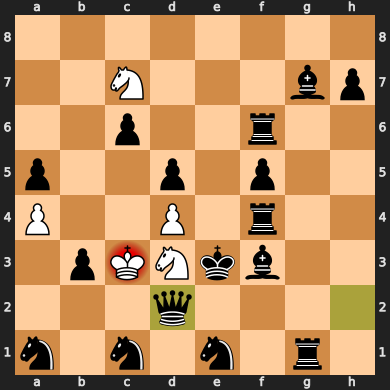

[Event "Bot Match"]
[Site "?"]
[Date "????.??.??"]
[Round "?"]
[White "Pacifist"]
[Black "SuicideKing"]
[Result "*"]

1. e3 { Safe move spotted } 1... Nc6 { No king moves!! } 2. a4 { Safe move spotted } 2... a5 { No king moves!! } 3. f3 { Safe move spotted } 3... Rb8 { No king moves!! } 4. Bc4 { Safe move spotted } 4... d5 { No king moves!! } 5. f4 { Safe move spotted } 5... Kd7 { King closing distance! } 6. Qe2 { Safe move spotted } 6... Ke6 { King closing distance! } 7. g3 { Safe move spotted } 7... Kf5 { King closing distance! } 8. Kd1 { Safe move spotted } 8... Ke4 { King closing distance! } 9. Ra3 { Safe move spotted } 9... e5 { King is close enough! } 10. b4 { Safe move spotted } 10... Qe7 { King is close enough! } 11. Ba2 { Safe move spotted } 11... Qd8 { King is close enough! } 12. b5 { Safe move spotted } 12... b6 { King is close enough! } 13. Bc4 { Safe move spotted } 13... Ba6 { King is close enough! } 14. Nh3 { Safe move spotted } 14... Kf5 { King is close enough! } 15. Bb2

In [374]:
engine = chess.engine.SimpleEngine.popen_uci("/content/stockfish_14_linux_x64_popcnt/stockfish_14_x64_popcnt")

base_limit = chess.engine.Limit(time=0.1, depth=10)

bot_ar = AlwaysRandomBot()
bot_sf = Stockfish100Bot(engine, base_limit)
bot_berserk = BerserkBot()
bot_panic = PanicFishBot(engine, base_limit)
bot_pacifist = PacifistBot()
bot_dance_king = DanceKingBot()
bot_suicide_king = SuicideKingBot()

# Water Bot levels
water_fish_80 = WaterBot(bot_sf, bot_ar, 0.8)
water_fish_80.custom_name = "WaterFish80"

water_fish_30 = WaterBot(bot_sf, bot_ar, 0.3)
water_fish_30.custom_name = "WaterFish30"

# Sharkfish
shark_fish = SharkFishBot(bot_ar, 0, 5, engine, base_limit)

# Test a game
game_result = play_game(bot_pacifist, bot_suicide_king, 500)
print(game_result.pc_board.outcome())

board_svg = chess.svg.board(game_result.pc_board)
display(game_result.pc_board)
print(game_result.pc_game)

## Water Bot Generation


In [ ]:
# creates list of bots
bots = []

def generate_water_bots(b1, b2, name=None):
  mixes = [0.1, 0.2, 0.8, 0.9]
  water_bots = []
  for mix in mixes:
    water_bot = WaterBot(b1, b2, mix)
    if not name == None:
      water_bot.custom_name = name + str(int(mix*100))
    water_bots.append(water_bot)
  return water_bots

# bots += generate_water_bots(bot_sf, bot_ar, "Waterfish")
# bots += generate_water_bots(bot_sf, bot_berserk, "Torrent")

for bot in bots:
  print(bot)

AlwaysRandom
PanicFish
Beserk


# Match Running

## Elo Calcuations

In [344]:
def win_prob(rating1, rating2):
  return 1.0 * 1.0 / (1 + 1.0 * math.pow(10, 1.0 * (rating2 - rating1) / 400))
  # Geeks for geeks was wrong..... their version has a typo int he above alg

# Takes 1 ELO,s a K value, and d = winner == 1
def calculate_elos(rating1, rating2, K, d):
  prob1 = win_prob(rating1, rating2)
  prob2 = win_prob(rating2, rating1)
  # print(prob1, prob2)
  # Case -1 When Player A wins
  if (d == 1):
    rating1 += K * (1 - prob1)
    rating2 += K * (0 - prob2)

  # Case -2 When Player B wins
  elif (d == 0):
    rating1 += K * (0 - prob1)
    rating2 += K * (1 - prob2)

  # Tie case
  else:
    rating1 += K * (0.5 - prob1)
    rating2 += K * (0.5 - prob2)
  
  return int(rating1), int(rating2)


print(calculate_elos(1200, 1000, 32, 0.5))
# Populate names and ELOs
elo_k = 32 # Determines how much Elo goes up and down


(1191, 1008)


## Multigame Match Setup

In [345]:
# Actually play the games

# Play a single game between bots
def play_game(wb: ChessBot, bb: ChessBot, turn_limit: int):
  board = chess.Board()
  game = chess.pgn.Game()
  node = game
  turns = 0

  start_time = time.time()
  while not board.is_game_over() and turns <= turn_limit:
    move = None
    if board.turn:
      move, comment = wb.make_move(board)
    else:
      move, comment = bb.make_move(board)
    node = node.add_variation(move)
    node.comment = comment
    board.push(move)
    turns +=1
  game.end()
  game_result = create_game_result(wb, bb, board, game)
  game_result.time = time.time() - start_time
  return game_result

# Helper to play multiple games between two bots
def multiplay(wb, bb, count, elos=None):
  grs = [] # game results array
  for i in range(count):
    print('Game [' + str(i+1) + '/' + str(count) + "] of [" + str(wb) + "] vs [" + str(bb) + "]")
    gr = play_game(wb, bb, 300)
    print(gr.winner + ' wins in [' + str(gr.moves) + '] turns in [' + str(gr.time) + '] seconds')
    if elos: # Update Elos case
      if str(wb) == str(bb):
        pass
      else:
        winner = 0.5
        if (gr.winner == str(wb)):
          winner = 1
        elif (gr.winner == str(bb)):
          winner = 0
        elos[str(wb)], elos[str(bb)] = calculate_elos(elos[str(wb)], elos[str(bb)], elo_k, winner)
        print(str(wb) + ': ' + str(elos[str(wb)]) + ', ' + str(bb) + ': ' + str(elos[str(bb)]))
    grs.append(gr)
  return grs

## Run Single Bot Match

In [295]:
def play_match(b1, b2, games_count, swap_colors=True, elos=None):
  print('=========<' + str(b1) +' [vs] ' + str(b2) + '>=========')
  # Time and play games
  start_time = time.time()
  grs = []
  
  grs += multiplay(b1, b2, games_count, elos)
  if swap_colors:
    grs += multiplay(b2, b1, games_count, elos) # switch colors
  end_time = time.time()
  print('Total Time: ' + str((end_time - start_time)))
  print()

  return grs

=========<AlwaysRandom [vs] Pacifist>=========
Game [1/3] of [AlwaysRandom] vs [Pacifist]
Draw wins in [151] turns in [0.20311498641967773] seconds
Game [2/3] of [AlwaysRandom] vs [Pacifist]
AlwaysRandom wins in [130] turns in [0.23230981826782227] seconds
Game [3/3] of [AlwaysRandom] vs [Pacifist]
Draw wins in [151] turns in [0.1888284683227539] seconds
Game [1/3] of [Pacifist] vs [AlwaysRandom]
Draw wins in [151] turns in [0.19818973541259766] seconds
Game [2/3] of [Pacifist] vs [AlwaysRandom]
AlwaysRandom wins in [73] turns in [0.1110377311706543] seconds
Game [3/3] of [Pacifist] vs [AlwaysRandom]
Draw wins in [151] turns in [0.17760276794433594] seconds
Total Time: 1.117335557937622

[<__main__.GameResult object at 0x7f1484277fa0>, <__main__.GameResult object at 0x7f147aafc9d0>, <__main__.GameResult object at 0x7f147b906e20>, <__main__.GameResult object at 0x7f147b8ca670>, <__main__.GameResult object at 0x7f147b3eff10>, <__main__.GameResult object at 0x7f147f914760>]
[AlwaysRandom]

## Run Bot Tournament



In [382]:
# Initializing bots
base_limit = chess.engine.Limit(time=0.1, depth=10)

shark_angry = SharkFishBot(bot_berserk, 0, 3, engine, base_limit)
shark_angry.custom_name = "BerserkShark"

shark_lurk = SharkFishBot(bot_berserk, 2, 7, engine, base_limit)
shark_lurk.custom_name = "LurkShark"

torrent_80 = WaterBot(bot_sf, bot_berserk, 0.8)
torrent_80.custom_name = 'Torrent80'

bots_x = [bot_dance_king, bot_suicide_king, bot_ar, bot_pacifist, bot_berserk, 
          shark_angry, shark_lurk, 
          torrent_80, water_fish_80, bot_sf,
          bot_panic]


# Setting up required resources
game_results = []
player_names = []
elos = {}
for bot in bots_x:
  player_names.append(str(bot))
  elos[str(bot)] = 800
print(player_names)


def play_tournament(bots, match_length, swap_colors):
  start_time = time.time()
  match_total = len(bots)**2
  match_count = 0
  grs = []
  for b1 in bots:
    for b2 in bots:
      match_count += 1
      # Play a single one-sided match (no color swapping)
      print('Match ' + str(match_count) + '/' + str(match_total))
      grs += play_match(b1, b2, match_length, swap_colors, elos)
  total_time = time.time() - start_time
  print('Total time for tournament: ' + str(total_time))
  return grs

### PLAY THE TOURNAMENT!
game_results = play_tournament(bots_x, 20, False)

# Bot Names for Labelling


Streaming output truncated to the last 5000 lines.
Torrent80 wins in [15] turns in [0.19012188911437988] seconds
Pacifist: 269, Torrent80: 947
Game [16/20] of [Pacifist] vs [Torrent80]
Torrent80 wins in [11] turns in [0.09825754165649414] seconds
Pacifist: 268, Torrent80: 947
Game [17/20] of [Pacifist] vs [Torrent80]
Torrent80 wins in [6] turns in [0.037545204162597656] seconds
Pacifist: 267, Torrent80: 947
Game [18/20] of [Pacifist] vs [Torrent80]
Torrent80 wins in [43] turns in [0.4074063301086426] seconds
Pacifist: 266, Torrent80: 947
Game [19/20] of [Pacifist] vs [Torrent80]
Torrent80 wins in [21] turns in [0.30591416358947754] seconds
Pacifist: 265, Torrent80: 947
Game [20/20] of [Pacifist] vs [Torrent80]
Torrent80 wins in [15] turns in [0.09710025787353516] seconds
Pacifist: 264, Torrent80: 947
Total Time: 4.01187539100647

Match 42/121
=========<Pacifist [vs] WaterFish80>=========
Game [1/20] of [Pacifist] vs [WaterFish80]
WaterFish80 wins in [24] turns in [0.15057849884033203] 

# Tournament Analysis

## Multigame Match Analysis

In [386]:
# Data into Pandas

winners = []
reasons = []
moves = []
times = []
pgns = []
whites = []
blacks = []

# Unzip array of game objects into arrays
for gr in game_results:
  winners.append(gr.winner)
  reasons.append(gr.end_reason)
  moves.append(gr.moves)
  times.append(gr.time)
  pgns.append(gr.pgn)
  whites.append(gr.white_player)
  blacks.append(gr.black_player)

# Settingup data in dict
game_data = {
    'Winner': winners, 
    'End Reason': reasons,
    'Moves': moves,
    'Time': times,
    'PGN': pgns,
    'White': whites,
    'Black': blacks
}

# Into Pandas :3
df = pd.DataFrame(game_data)
df.to_csv('output.csv', encoding = 'utf-8-sig') 
files.download('output.csv')
df

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Winner,End Reason,Moves,Time,PGN,White,Black
0,Stalemate,FIVEFOLD_REPETITION,41,0.184014,"[Event ""Bot Match""]\n[Site ""?""]\n[Date ""????.?...",DanceKing,DanceKing
1,Stalemate,SEVENTYFIVE_MOVES,82,0.240908,"[Event ""Bot Match""]\n[Site ""?""]\n[Date ""????.?...",DanceKing,DanceKing
2,Stalemate,SEVENTYFIVE_MOVES,118,0.252031,"[Event ""Bot Match""]\n[Site ""?""]\n[Date ""????.?...",DanceKing,DanceKing
3,Stalemate,SEVENTYFIVE_MOVES,108,0.213916,"[Event ""Bot Match""]\n[Site ""?""]\n[Date ""????.?...",DanceKing,DanceKing
4,Stalemate,FIVEFOLD_REPETITION,27,0.054284,"[Event ""Bot Match""]\n[Site ""?""]\n[Date ""????.?...",DanceKing,DanceKing
...,...,...,...,...,...,...,...
2415,PanicFish,CHECKMATE,42,1.317592,"[Event ""Bot Match""]\n[Site ""?""]\n[Date ""????.?...",PanicFish,PanicFish
2416,PanicFish,CHECKMATE,64,2.144035,"[Event ""Bot Match""]\n[Site ""?""]\n[Date ""????.?...",PanicFish,PanicFish
2417,Stalemate,FIVEFOLD_REPETITION,50,1.496801,"[Event ""Bot Match""]\n[Site ""?""]\n[Date ""????.?...",PanicFish,PanicFish
2418,PanicFish,CHECKMATE,96,2.158047,"[Event ""Bot Match""]\n[Site ""?""]\n[Date ""????.?...",PanicFish,PanicFish


In [384]:
# Summary Analysis of DF
df.groupby("Winner").count()
# Win percents
df['Winner'].value_counts(normalize=True)

SF:Limit(time=0.1, depth=10)    0.166116
PanicFish                       0.146694
WaterFish80                     0.126446
Torrent80                       0.124793
BerserkShark                    0.098760
LurkShark                       0.093388
Stalemate                       0.088017
Draw                            0.083471
Berserk                         0.029752
AlwaysRandom                    0.022727
SuicideKing                     0.018595
DanceKing                       0.001240
Name: Winner, dtype: float64

## Elo Chart

{'DanceKing': 360, 'SuicideKing': 381, 'AlwaysRandom': 315, 'Pacifist': 80, 'Berserk': 303, 'BerserkShark': 748, 'LurkShark': 610, 'Torrent80': 789, 'WaterFish80': 626, 'SF:Limit(time=0.1, depth=10)': 1372, 'PanicFish': 1021}
[('Pacifist', 80), ('Berserk', 303), ('AlwaysRandom', 315), ('DanceKing', 360), ('SuicideKing', 381), ('LurkShark', 610), ('WaterFish80', 626), ('BerserkShark', 748), ('Torrent80', 789), ('PanicFish', 1021), ('SF:Limit(time=0.1, depth=10)', 1372)]


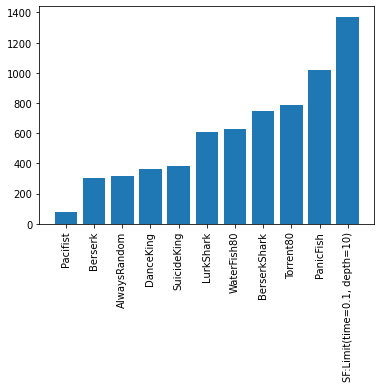

In [385]:
print(elos)
kvs = list(elos.items())
kvs.sort(key= lambda x: x[1])
print(kvs)
names_by_elo, elo_values = zip(*kvs)

plt.bar(range(len(elos)), elo_values, tick_label=names_by_elo)
plt.xticks(rotation=90)
plt.show()

## Matchup Chart Creation

In [391]:
matchups_dict = {}
round_to_decimals = 3

# overwrite playernames to be sorted by elo
player_names = names_by_elo

for white_player in player_names:
  matchups_dict[white_player] = {}
  for black_player in player_names:
    # Collect all matches from database with white player and black player
    # Consolidate them into stalement and win/loss/staledraw (store as tuple first?)
      # In future, cinlude more info, like average move length
    white_wins = 0.0
    white_drawmates = 0.0
    white_losses = 0.0
    for index, item in df.loc[(df['White'] == white_player) & (df['Black'] == black_player)]['Winner'].value_counts(normalize=True).items():
      # Value will be one of white_player, black_player, draw, or Stalement (Stalemate)
      if index == white_player:
        white_wins = round(item, round_to_decimals)
      elif (index == 'Stalemate') or (index == 'Draw'):
        white_drawmates += round(item, round_to_decimals)
    white_losses = round(1 - (white_wins + white_drawmates), round_to_decimals)
    
    # Append to dict
    matchups_dict[white_player][black_player] = (white_wins, white_drawmates, white_losses)
    # matchups_dict[white_player][black_player] = white_wins
matchups_df = pd.DataFrame(matchups_dict)
matchups_df

,Pacifist,Berserk,AlwaysRandom,DanceKing,SuicideKing,LurkShark,WaterFish80,BerserkShark,Torrent80,PanicFish,"SF:Limit(time=0.1, depth=10)"
Pacifist,"(0.0, 1.0, 0.0)","(0.8, 0.2, 0.0)","(0.7, 0.30000000000000004, 0.0)","(0.0, 1.0, 0.0)","(0.6, 0.4, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)"
Berserk,"(0.0, 0.35, 0.65)","(0.0, 1.0, 0.0)","(0.0, 0.8, 0.2)","(0.0, 0.7, 0.3)","(0.0, 0.5, 0.5)","(0.85, 0.15, 0.0)","(1.0, 0.0, 0.0)","(0.95, 0.05, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)"
AlwaysRandom,"(0.0, 0.44999999999999996, 0.55)","(0.35, 0.65, 0.0)","(0.1, 0.9, 0.0)","(0.0, 0.8500000000000001, 0.15)","(0.0, 0.3, 0.7)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)"
DanceKing,"(0.0, 1.0, 0.0)","(0.45, 0.55, 0.0)","(0.25, 0.75, 0.0)","(0.0, 1.0, 0.0)","(0.25, 0.65, 0.1)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)"
SuicideKing,"(0.0, 0.45, 0.55)","(0.3, 0.65, 0.05)","(0.3, 0.5, 0.2)","(0.05, 0.75, 0.2)","(0.4, 0.6, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)"
LurkShark,"(0.0, 0.0, 1.0)","(0.0, 0.05, 0.95)","(0.0, 0.0, 1.0)","(0.0, 0.0, 1.0)","(0.0, 0.0, 1.0)","(0.3, 0.7, 0.0)","(0.75, 0.05, 0.2)","(0.3, 0.35, 0.35)","(0.75, 0.1, 0.15)","(0.95, 0.05, 0.0)","(1.0, 0.0, 0.0)"
WaterFish80,"(0.0, 0.0, 1.0)","(0.05, 0.0, 0.95)","(0.0, 0.0, 1.0)","(0.0, 0.0, 1.0)","(0.0, 0.0, 1.0)","(0.05, 0.0, 0.95)","(1.0, 0.0, 0.0)","(0.2, 0.05, 0.75)","(0.4, 0.05, 0.55)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)"
BerserkShark,"(0.0, 0.0, 1.0)","(0.0, 0.05, 0.95)","(0.0, 0.0, 1.0)","(0.0, 0.0, 1.0)","(0.0, 0.0, 1.0)","(0.3, 0.1, 0.6)","(0.85, 0.1, 0.05)","(0.05, 0.95, 0.0)","(0.8, 0.1, 0.1)","(0.75, 0.0, 0.25)","(1.0, 0.0, 0.0)"
Torrent80,"(0.0, 0.0, 1.0)","(0.0, 0.0, 1.0)","(0.0, 0.0, 1.0)","(0.0, 0.0, 1.0)","(0.0, 0.0, 1.0)","(0.1, 0.1, 0.8)","(0.5, 0.05, 0.45)","(0.25, 0.2, 0.55)","(0.8, 0.2, 0.0)","(0.8, 0.05, 0.15)","(1.0, 0.0, 0.0)"
PanicFish,"(0.0, 0.0, 1.0)","(0.0, 0.0, 1.0)","(0.0, 0.0, 1.0)","(0.0, 0.0, 1.0)","(0.0, 0.0, 1.0)","(0.05, 0.0, 0.95)","(0.0, 0.0, 1.0)","(0.25, 0.05, 0.7)","(0.4, 0.0, 0.6)","(0.9, 0.1, 0.0)","(0.8, 0.1, 0.1)"


https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html

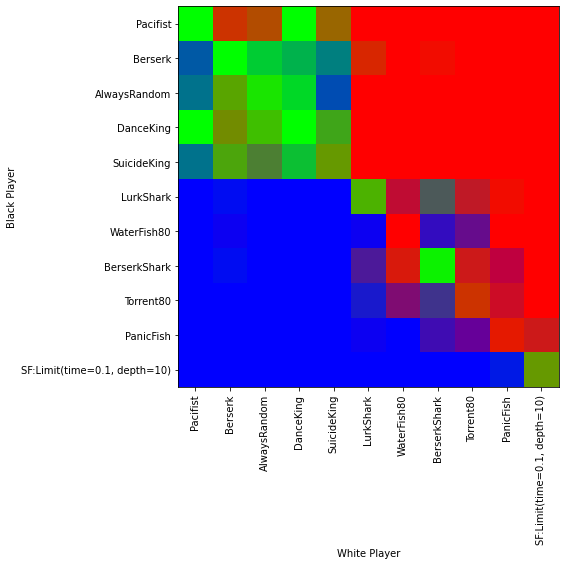

In [392]:
ticks = player_names


matchups_rgb = np.array(matchups_df.values.tolist()).astype('float')
def scale_rgb(i):
  new = (i * 0.5) + 0.25
  return i
   
applyall = np.vectorize(scale_rgb)
matchups_rgb = applyall(matchups_rgb)

plt.figure(figsize = (7,7))
plt.xlabel("White Player")
plt.ylabel("Black Player")
plt.xticks(range(len(player_names)), player_names, rotation=90)
plt.yticks(range(len(player_names)), player_names)
plt.imshow(matchups_rgb)
plt.show()

## Time Chart

In [205]:
df.loc[(df['White'] == 'Torrent80') & (df['Black'] == 'Torrent80')]['Time'].sum()

0.0

In [393]:
matchup_times_dict = {}
for white_player in player_names:
  matchup_times_dict[white_player] = {}
  for black_player in player_names:
    # Collect all matches from database with white player and black player
    # Consolidate them into stalement and win/loss/staledraw (store as tuple first?)
      # In future, cinlude more info, like average move length
    total_time = df.loc[(df['White'] == white_player) & (df['Black'] == black_player)]['Time'].sum()

    # Append to dict
    matchup_times_dict[white_player][black_player] = total_time
    # matchups_dict[white_player][black_player] = white_wins
matchup_times_df = pd.DataFrame(matchup_times_dict)
matchup_times_df

,Pacifist,Berserk,AlwaysRandom,DanceKing,SuicideKing,LurkShark,WaterFish80,BerserkShark,Torrent80,PanicFish,"SF:Limit(time=0.1, depth=10)"
Pacifist,10.543921,1.802454,4.174457,6.442947,3.324230,4.624124,5.676778,2.843708,5.322397,3.506414,5.524318
Berserk,3.767518,2.732252,3.370652,1.859790,1.258810,6.289881,4.892177,4.875626,3.967464,2.981183,3.526912
AlwaysRandom,4.634326,1.676327,1.665206,2.475787,0.732966,4.004652,3.806824,5.175006,6.345392,4.213561,5.087883
DanceKing,6.385888,1.865435,1.285655,3.316129,1.863189,2.474575,3.495180,3.617582,3.455189,3.998466,4.226228
SuicideKing,6.007453,1.442002,0.878470,2.170966,1.055508,2.758832,3.076860,4.343266,2.160391,3.898772,2.390659
LurkShark,2.701988,5.101955,3.572707,4.960437,2.069437,15.330550,13.680740,16.520482,13.375457,11.614400,10.588107
WaterFish80,4.891518,7.165720,5.448363,4.367058,4.484701,14.836972,18.936958,12.511581,17.914324,14.891185,14.905948
BerserkShark,4.942631,8.352249,5.801208,4.097878,1.472076,13.595433,13.931837,18.030458,13.225733,12.764547,8.048878
Torrent80,3.995110,4.946283,3.395997,5.603182,3.268427,15.121373,17.522812,17.067598,16.714582,16.492345,12.027750
PanicFish,4.245072,4.267211,3.909075,5.449726,3.192371,13.042202,15.442520,14.417740,16.638127,25.832833,25.322666


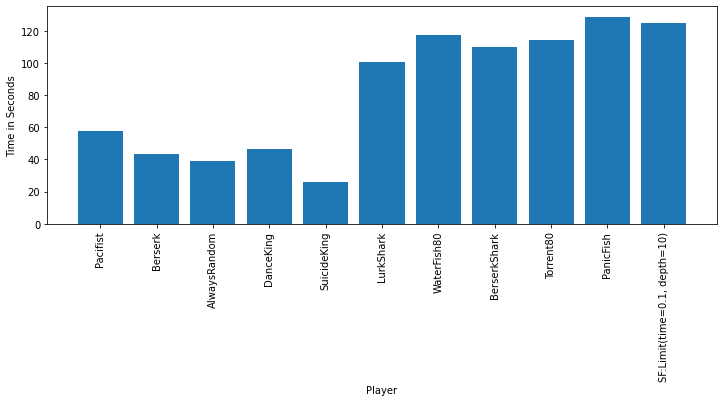

In [403]:
times_sum = matchup_times_df.sum()
plt.figure(figsize = (12,4))
plt.xlabel("Player")
plt.ylabel("Time in Seconds")
plt.bar(player_names, times_sum)
plt.xticks(rotation=90)
plt.show()

https://www.w3schools.com/python/matplotlib_pie_charts.asp

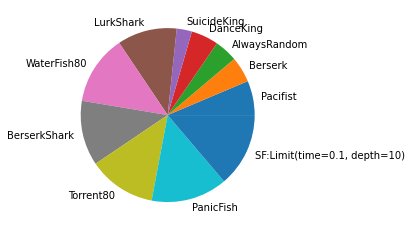

In [396]:
plt.pie(times_sum, labels=player_names)
plt.show()

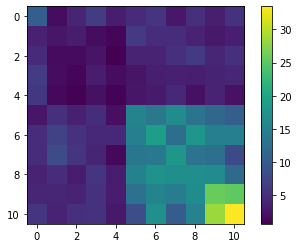

In [395]:
# make plot
fig, ax = plt.subplots()
shw = ax.imshow(matchup_times_df)
bar = plt.colorbar(shw)
  


## Misc Searches

In [401]:
# Selecting rows based on column values, notice use of & instead of and for boolean
df.loc[(df['White'] == 'AlwaysRandom') & (df['Black'] == 'RandShark')] 

# Iterating through example
for index, row in df.loc[(df['White'] == 'AlwaysRandom') & (df['Black'] == 'RandShark')].iterrows():
  print(row['Winner'])

# Get Win proportions for a single match
df.loc[(df['White'] == 'AlwaysRandom') & (df['Black'] == 'RandShark')]['Winner'].value_counts(normalize=True)
for index, item in df.loc[(df['White'] == 'AlwaysRandom') & (df['Black'] == 'RandShark')]['Winner'].value_counts(normalize=True).items():
  print(index, item)
# Idea: for every both, calculate its win percent against the other bot as the color

df.loc[(df['Winner'] == 'DanceKing')] 


,Winner,End Reason,Moves,Time,PGN,White,Black
38,DanceKing,CHECKMATE,49,0.036837,"[Event ""Bot Match""]\n[Site ""?""]\n[Date ""????.?...",DanceKing,SuicideKing
220,DanceKing,CHECKMATE,127,0.110338,"[Event ""Bot Match""]\n[Site ""?""]\n[Date ""????.?...",SuicideKing,DanceKing
234,DanceKing,CHECKMATE,22,0.017351,"[Event ""Bot Match""]\n[Site ""?""]\n[Date ""????.?...",SuicideKing,DanceKing


# Playing with Stockfish Depths





## Testing multiple thinking times with default depth

In [194]:
engine = chess.engine.SimpleEngine.popen_uci("/content/stockfish_14_linux_x64_popcnt/stockfish_14_x64_popcnt")
eg_sf = Stockfish100Bot(engine, base_limit)

def generate_limits(time_depth_arr):
  lims = []
  for time_depth in time_depth_arr:
    time, depth = time_depth
    lim = chess.engine.Limit
    if depth == -1:
      lim = chess.engine.Limit(time)
    else:
      lim = chess.engine.Limit(time, depth)
    lims.append(lim)
  return lims
  
def generate_sf_bots(lims):
  bots = []
  for lim in lims:
    sf = Stockfish100Bot(engine, lim)
    bots.append(sf)
  return bots

time_depths = [
    (0.1, 2),
    (0.1, 4),
    (0.1, 6),
    (0.1, 8),
    (0.1, 10),
    (0.1, 15),
    (0.1, 20),
    (0.1, -1)
]
      
lims = generate_limits(time_depths)
sf_bots = generate_sf_bots(lims)

In [195]:
game_results = play_tournament(sf_bots, 5, False)

=========<SF:Limit(time=0.1, depth=2) [vs] SF:Limit(time=0.1, depth=2)>=========
Game [1/5] of [SF:Limit(time=0.1, depth=2)] vs [SF:Limit(time=0.1, depth=2)]
SF:Limit(time=0.1, depth=2) wins in [49] turns in [0.1624584197998047] seconds
Game [2/5] of [SF:Limit(time=0.1, depth=2)] vs [SF:Limit(time=0.1, depth=2)]
SF:Limit(time=0.1, depth=2) wins in [45] turns in [0.16147136688232422] seconds
Game [3/5] of [SF:Limit(time=0.1, depth=2)] vs [SF:Limit(time=0.1, depth=2)]
SF:Limit(time=0.1, depth=2) wins in [57] turns in [0.16152358055114746] seconds
Game [4/5] of [SF:Limit(time=0.1, depth=2)] vs [SF:Limit(time=0.1, depth=2)]
SF:Limit(time=0.1, depth=2) wins in [35] turns in [0.10573339462280273] seconds
Game [5/5] of [SF:Limit(time=0.1, depth=2)] vs [SF:Limit(time=0.1, depth=2)]
SF:Limit(time=0.1, depth=2) wins in [62] turns in [0.2063295841217041] seconds
Total Time: 0.8007831573486328

=========<SF:Limit(time=0.1, depth=2) [vs] SF:Limit(time=0.1, depth=4)>=========
Game [1/5] of [SF:Limit

In [197]:
player_names = []
for bot in sf_bots:
  player_names.append(str(bot))
print(player_names)

['SF:Limit(time=0.1, depth=2)', 'SF:Limit(time=0.1, depth=4)', 'SF:Limit(time=0.1, depth=6)', 'SF:Limit(time=0.1, depth=8)', 'SF:Limit(time=0.1, depth=10)', 'SF:Limit(time=0.1, depth=15)', 'SF:Limit(time=0.1, depth=20)', 'SF:Limit(time=0.1)']
